## Data Cleaning and Preprocessing

First, let's clean and prepare the electricity statistics data for analysis. We'll:
1. Load the data using pandas
2. Clean missing values and data types
3. Remove redundant rows
4. Create useful aggregations by technology and year

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('ELEC-C_20251021-194145.csv', skiprows=1)  # Skip the descriptive first row

# Replace '-' with NaN for proper handling of missing values
df = df.replace('-', np.nan)

# Convert numeric columns to appropriate data types
df['Electricity statistics'] = pd.to_numeric(df['Electricity statistics'], errors='coerce')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Create separate DataFrames for capacity and generation
capacity_df = df[df['Data Type'].str.contains('Capacity', na=False)].copy()
generation_df = df[df['Data Type'].str.contains('Generation', na=False)].copy()

# Remove redundant grid connection data (keep only 'All' for now)
capacity_df = capacity_df[capacity_df['Grid connection'] == 'All']
generation_df = generation_df[generation_df['Grid connection'] == 'All']

# Sort values by Year and Technology
capacity_df = capacity_df.sort_values(['Year', 'Technology'])
generation_df = generation_df.sort_values(['Year', 'Technology'])

# Create pivot tables for easier analysis
capacity_pivot = pd.pivot_table(
    capacity_df,
    values='Electricity statistics',
    index=['Year'],
    columns=['Technology'],
    aggfunc='first'
)

generation_pivot = pd.pivot_table(
    generation_df,
    values='Electricity statistics',
    index=['Year'],
    columns=['Technology'],
    aggfunc='first'
)

print("Data cleaning completed. Created separate DataFrames for:")
print(f"1. Capacity data: {capacity_df.shape}")
print(f"2. Generation data: {generation_df.shape}")
print("\nPivot tables created with years as rows and technologies as columns.")

Data cleaning completed. Created separate DataFrames for:
1. Capacity data: (210, 6)
2. Generation data: (210, 6)

Pivot tables created with years as rows and technologies as columns.


Let's examine the cleaned data by looking at some key metrics and visualizations:
1. Summary statistics for capacity and generation
2. Data completeness check
3. Quick trend visualization for main technologies

Capacity Statistics (MW):
                            count       mean          std      min        25%  \
Technology                                                                      
Biogas                       10.0     275.10    76.248789    179.0    213.500   
Coal and peat                10.0    7974.50  2377.514073   3714.0   6310.000   
Fossil fuels n.e.s.          10.0    1502.60   135.826033   1358.0   1374.500   
Geothermal energy             0.0        NaN          NaN      NaN        NaN   
Liquid biofuels               0.0        NaN          NaN      NaN        NaN   
Marine energy                10.0      10.46    10.059291      0.5      1.200   
Mixed Hydro Plants            0.0        NaN          NaN      NaN        NaN   
Natural gas                  10.0   18512.10  1644.300557  16873.0  17492.250   
Nuclear                      10.0   13279.60   588.664628  12513.0  12773.000   
Offshore wind energy          0.0        NaN          NaN      NaN        NaN   
Oi

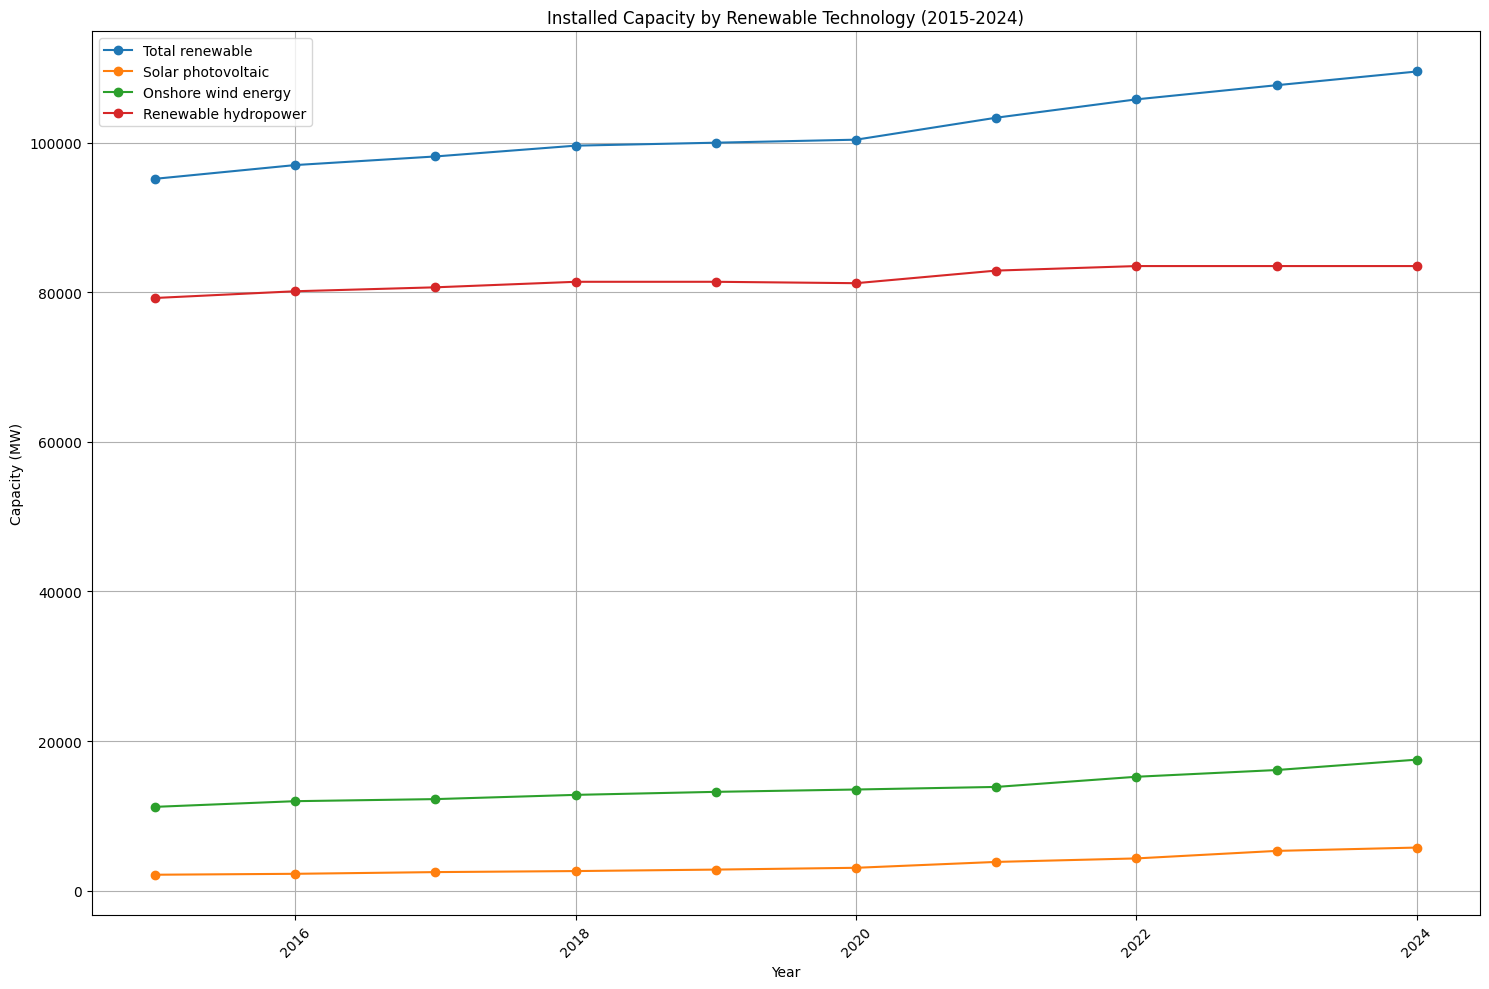

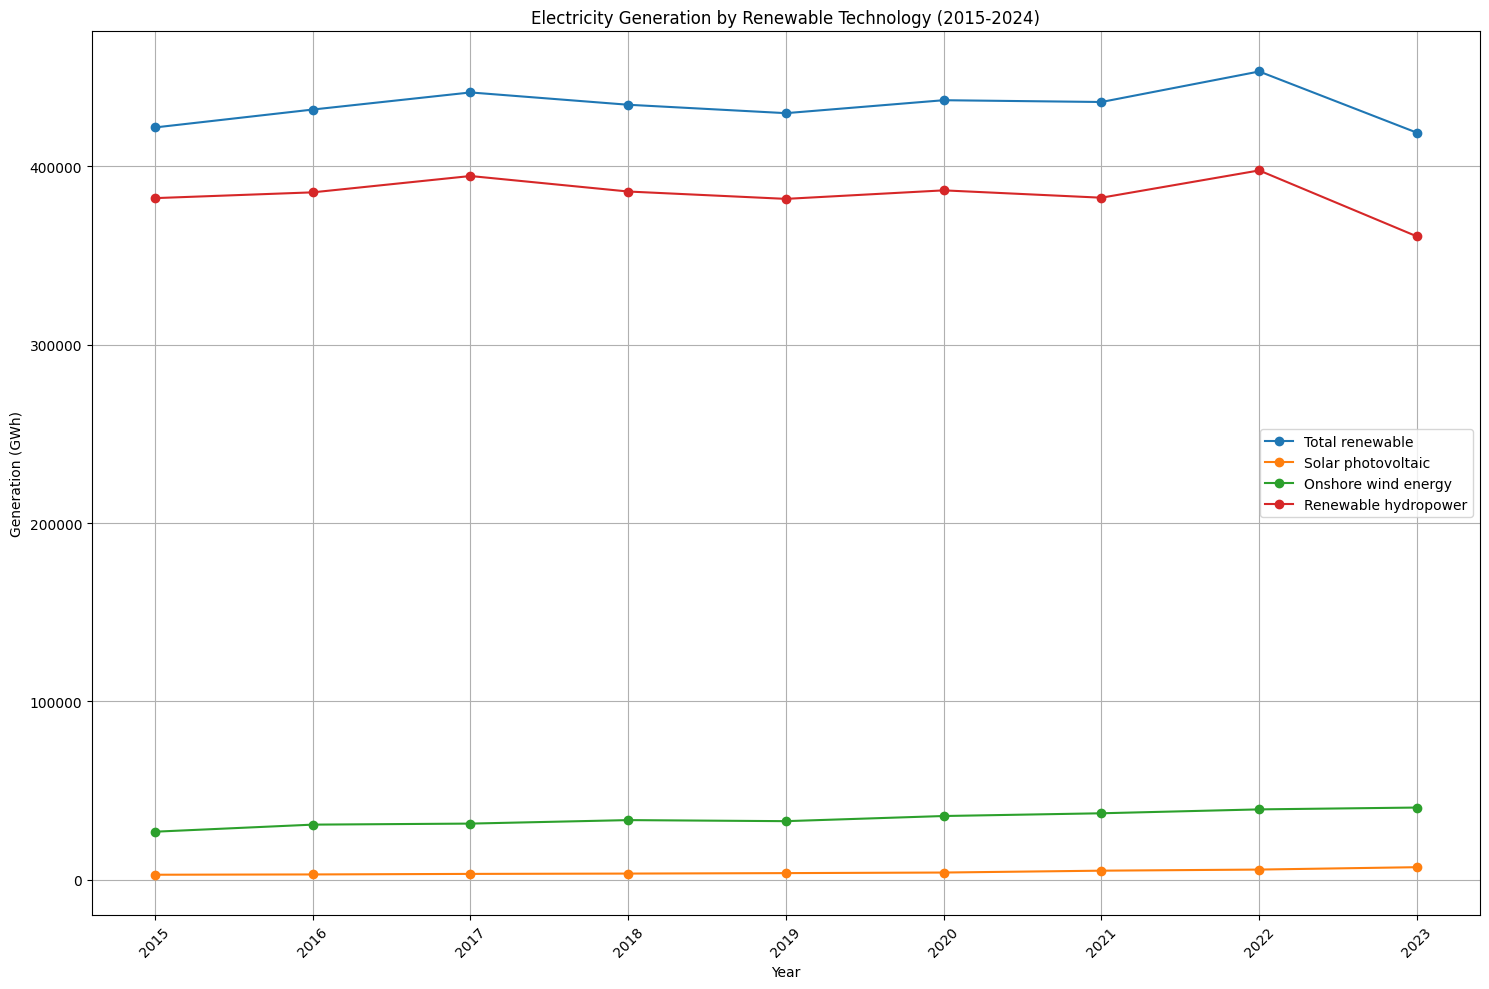

In [2]:
# 1. Summary statistics
print("Capacity Statistics (MW):")
print(capacity_df.groupby('Technology')['Electricity statistics'].describe())
print("\nGeneration Statistics (GWh):")
print(generation_df.groupby('Technology')['Electricity statistics'].describe())

# 2. Data completeness check
print("\nMissing values in capacity data:")
print(capacity_df.isna().sum())
print("\nMissing values in generation data:")
print(generation_df.isna().sum())

# 3. Visualize trends for major renewable sources
renewable_sources = ['Total renewable', 'Solar photovoltaic', 'Onshore wind energy', 'Renewable hydropower']

# Plotting
plt.figure(figsize=(15, 10))
for source in renewable_sources:
    plt.plot(capacity_pivot.index, capacity_pivot[source], marker='o', label=source)

plt.title('Installed Capacity by Renewable Technology (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Capacity (MW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Generation trends
plt.figure(figsize=(15, 10))
for source in renewable_sources:
    plt.plot(generation_pivot.index, generation_pivot[source], marker='o', label=source)

plt.title('Electricity Generation by Renewable Technology (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Generation (GWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's calculate some key insights about renewable energy trends:
1. Year-over-year growth rates
2. Renewable vs Non-renewable share
3. Technology-wise contribution to total renewable capacity

Year-over-Year Growth Rates (%):
Technology  Total renewable  Solar photovoltaic  Onshore wind energy  \
Year                                                                   
2015                    NaN                 NaN                  NaN   
2016                   1.93                5.79                 6.77   
2017                   1.19               10.07                 2.31   
2018                   1.47                5.54                 4.62   
2019                   0.40                7.49                 3.15   
2020                   0.40                8.49                 2.36   
2021                   2.93               25.62                 2.56   
2022                   2.37               12.17                 9.79   
2023                   1.79               23.25                 5.91   
2024                   1.70                8.36                 8.59   

Technology  Renewable hydropower  
Year                              
2015                         NaN

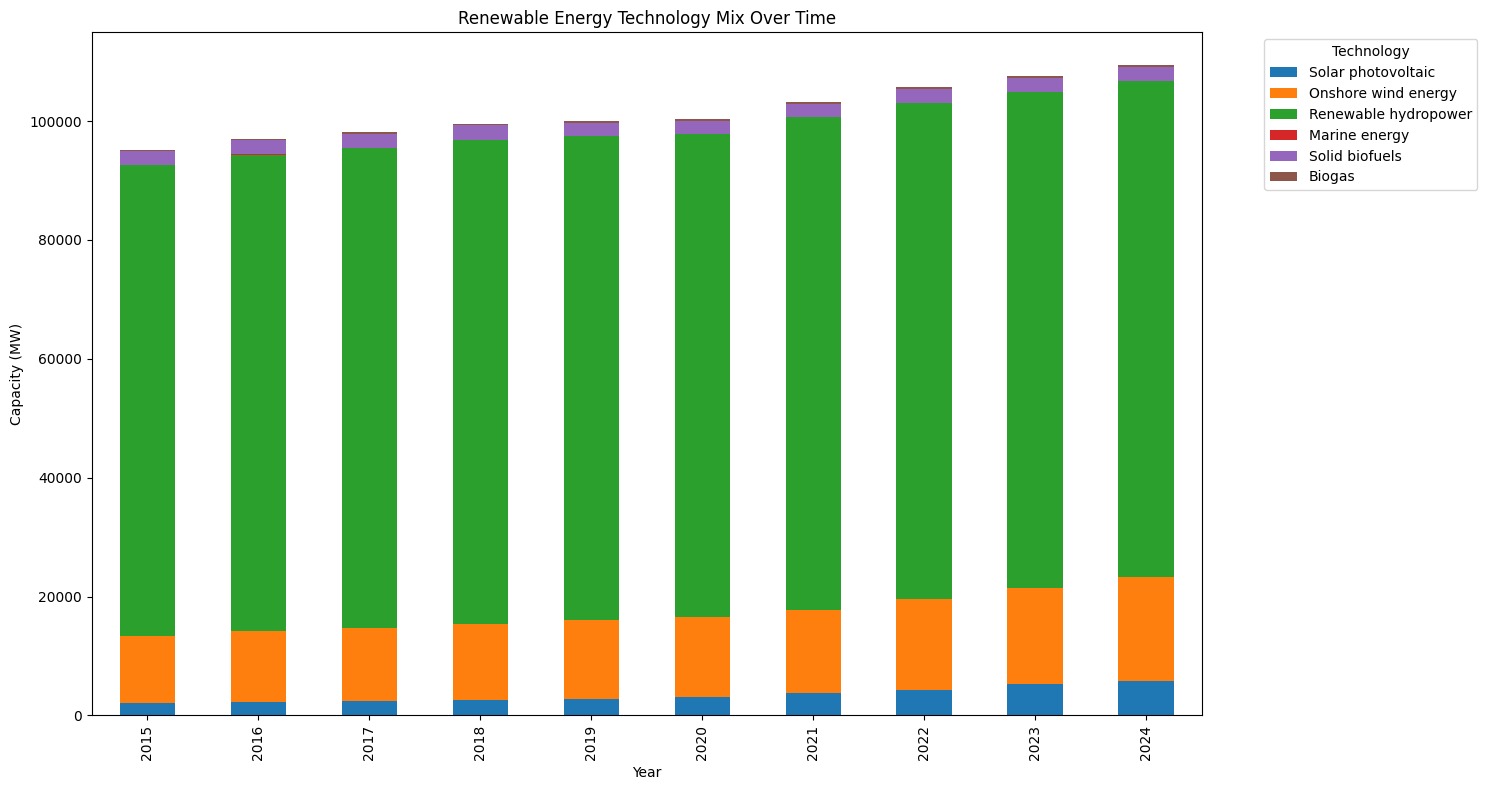


Technology Contribution to Total Renewable Capacity (%) in 2024
Solar photovoltaic: 5.27%
Onshore wind energy: 16.01%
Renewable hydropower: 76.28%
Marine energy: 0.0%
Solid biofuels: 2.12%
Biogas: 0.32%


In [3]:
# Calculate year-over-year growth rates for renewable technologies
yoy_growth = capacity_pivot.pct_change() * 100

print("Year-over-Year Growth Rates (%):")
print(yoy_growth[renewable_sources].round(2))

# Calculate renewable vs non-renewable share
total_capacity = capacity_pivot['Total renewable'] + capacity_pivot['Total non-renewable']
renewable_share = (capacity_pivot['Total renewable'] / total_capacity * 100).round(2)
nonrenewable_share = (capacity_pivot['Total non-renewable'] / total_capacity * 100).round(2)

print("\nRenewable vs Non-renewable Share (%):")
share_df = pd.DataFrame({
    'Renewable': renewable_share,
    'Non-renewable': nonrenewable_share
})
print(share_df)

# Calculate technology contribution to total renewable capacity
renewable_techs = ['Solar photovoltaic', 'Onshore wind energy', 'Renewable hydropower', 
                  'Marine energy', 'Solid biofuels', 'Biogas']

# Create a stacked bar chart
renewable_capacity = capacity_pivot[renewable_techs]
ax = renewable_capacity.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Renewable Energy Technology Mix Over Time')
plt.xlabel('Year')
plt.ylabel('Capacity (MW)')
plt.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate percentage contribution for the latest year
latest_year = capacity_pivot.index.max()
latest_contributions = (renewable_capacity.loc[latest_year] / 
                       renewable_capacity.loc[latest_year].sum() * 100).round(2)

print("\nTechnology Contribution to Total Renewable Capacity (%) in", latest_year)
for tech, contrib in latest_contributions.items():
    print(f"{tech}: {contrib}%")

Finally, let's save the cleaned data to CSV files for future use and create a summary of key findings:

In [4]:
# Save cleaned data
capacity_pivot.to_csv('cleaned_capacity_data.csv')
generation_pivot.to_csv('cleaned_generation_data.csv')

print("Saved cleaned data to:")
print("1. cleaned_capacity_data.csv")
print("2. cleaned_generation_data.csv")

# Create summary statistics for the latest year
latest_year = capacity_pivot.index.max()

summary = pd.DataFrame({
    'Metric': [
        'Total Renewable Capacity (MW)',
        'Total Non-renewable Capacity (MW)',
        'Renewable Share (%)',
        'Top Renewable Source',
        'Solar Capacity Growth (2015-2024)',
        'Wind Capacity Growth (2015-2024)'
    ],
    'Value': [
        f"{capacity_pivot.loc[latest_year, 'Total renewable']:,.2f}",
        f"{capacity_pivot.loc[latest_year, 'Total non-renewable']:,.2f}",
        f"{renewable_share.loc[latest_year]:.1f}%",
        'Hydropower',
        f"{((capacity_pivot.loc[latest_year, 'Solar photovoltaic'] / capacity_pivot.loc[2015, 'Solar photovoltaic']) - 1) * 100:.1f}%",
        f"{((capacity_pivot.loc[latest_year, 'Onshore wind energy'] / capacity_pivot.loc[2015, 'Onshore wind energy']) - 1) * 100:.1f}%"
    ]
})

print("\nKey Findings for", latest_year)
print("-" * 50)
print(summary.to_string(index=False))

Saved cleaned data to:
1. cleaned_capacity_data.csv
2. cleaned_generation_data.csv

Key Findings for 2024
--------------------------------------------------
                           Metric      Value
    Total Renewable Capacity (MW) 109,504.50
Total Non-renewable Capacity (MW)  45,272.00
              Renewable Share (%)      70.8%
             Top Renewable Source Hydropower
Solar Capacity Growth (2015-2024)     169.7%
 Wind Capacity Growth (2015-2024)      56.3%
